Spike trains are generated using univariate, self‐exciting Hawkes point process with an exponential kernel, using Ogata’s thinning algorithm. 

In [1]:
import numpy as np
import pandas as pd

from scipy.optimize import curve_fit
from statsmodels.tsa.stattools import acf

from datetime import datetime

import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from cfg_global import project_folder_path
from calculate_tau import func_single_exp_monkey, fit_single_exp
from calculate_acf import acf_sttc
from spike_train_utils import bin_spike_train_fixed_len
os.chdir(current_wd)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
save_folder = project_folder_path + 'results\\synthetic_data\\dataset\\'
fig_folder = project_folder_path + 'results\\synthetic_data\\fig_drafts_paper_reduce\\'

#### Load spike trains

In [ ]:
# rate_hz     = 3.5     # target firing rate (Hz)
# tau_ms      = 100.0    # desired autocorr time constant (ms)
# alpha       = 0.3      # self‐excitation weight (must be <1)

In [60]:
all_spike_trains = np.load(save_folder + 'spike_trains_tau100ms_alpha0_3_fr3_5hz_len600sec_1000.npy', allow_pickle=True)
print(f'n spike trains {len(all_spike_trains)}, len {all_spike_trains[0][-1]/1000}')

duration_ms = 600 * 1000
target_fr_hz = 3.5
target_tau_ms = 100

fs = 1000

n spike trains 1000, len 599.4657698736828


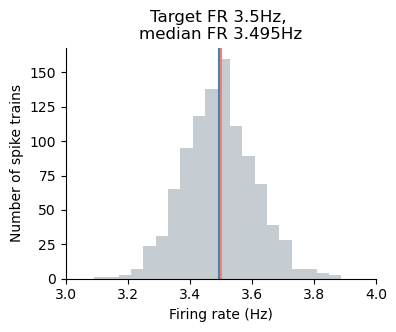

In [23]:
# Compute firing rates (Hz)
duration_s = duration_ms / 1000.0
rates = [len(train) / duration_s for train in all_spike_trains]

fig, axes = plt.subplots(1,1, figsize=(4,3))

axes.hist(rates, bins=20, color='slategray', alpha=0.4)
axes.axvline(x=target_fr_hz, color='salmon')
axes.axvline(x=np.median(rates), color='steelblue')
axes.set_xlabel('Firing rate (Hz)')
axes.set_ylabel('Number of spike trains')
axes.set_title(f'Target FR {target_fr_hz}Hz, \nmedian FR {np.round(np.median(rates),4)}Hz')
axes.set_xlim([3,4])

sns.despine()

#### Calculate acf and taus

##### ACFs

In [26]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags+1)]
print('acf_cols {}'.format(acf_cols))

bin_size = int(50 * (fs / 1000))
sttc_dt = int(25 * (fs / 1000))

calc_acf_full = True
calc_isttc_full = True

acf_cols ['acf_0', 'acf_1', 'acf_2', 'acf_3', 'acf_4', 'acf_5', 'acf_6', 'acf_7', 'acf_8', 'acf_9', 'acf_10', 'acf_11', 'acf_12', 'acf_13', 'acf_14', 'acf_15', 'acf_16', 'acf_17', 'acf_18', 'acf_19', 'acf_20']


In [27]:
all_spike_trains_binned_l = []
for i in range(len(all_spike_trains)):
    binned_spike_train = bin_spike_train_fixed_len([int(spike) for spike in all_spike_trains[i]],
                                                   bin_size, fs, duration_ms,
                                                   verbose_=False)
    all_spike_trains_binned_l.append(binned_spike_train)

In [29]:
if calc_acf_full:
    acf_full_l = []
    for unit_idx, unit in enumerate(all_spike_trains_binned_l):
        if unit_idx % 100 == 0:
            print(f'Processing unit {unit_idx}')
        spike_train_binned_acf = acf(unit, nlags=n_lags)
        acf_full_l.append(spike_train_binned_acf)
    
    acf_full_df = pd.DataFrame(np.array(acf_full_l), columns=acf_cols)
    print('NaNs in acf {}'.format(acf_full_df.isnull().any().any()))
    acf_full_df.head(3)
    
    # acf_full_df.to_pickle(dataset_folder + 'cut_30min\\binned\\acf\\acf_full_50ms_20lags_df.pkl')

Processing unit 0
Processing unit 100
Processing unit 200
Processing unit 300
Processing unit 400
Processing unit 500
Processing unit 600
Processing unit 700
Processing unit 800
Processing unit 900
NaNs in acf False


In [30]:
if calc_isttc_full:
    acf_isttc_full_l = []
    for unit_idx, unit in enumerate(all_spike_trains):
        if unit_idx % 100 == 0:
            print(f'Processing unit {unit_idx}')
        spike_train_int = np.asarray([int(spike) for spike in unit])
        spike_train_acf = acf_sttc(spike_train_int, n_lags, bin_size, sttc_dt, duration_ms, verbose_=False)
        acf_isttc_full_l.append(spike_train_acf)
    
    acf_isttc_full_df = pd.DataFrame(np.array(acf_isttc_full_l), columns=acf_cols)
    print('NaNs in acf {}'.format(acf_isttc_full_df.isnull().any().any()))
    acf_isttc_full_df.head(3)

Processing unit 0
Processing unit 100
Processing unit 200
Processing unit 300
Processing unit 400
Processing unit 500
Processing unit 600
Processing unit 700
Processing unit 800
Processing unit 900
NaNs in acf False


##### Taus

In [31]:
calc_taus = True

In [32]:
if calc_taus:
    acf_full_2d = acf_full_df[acf_cols].values
    print(f'acf_2d shape {acf_full_2d.shape}')
    acf_full_unit_ids = acf_full_df.index.values
    print(f'acf_full_unit_ids shape {acf_full_unit_ids.shape}')
    
    acf_full_dict = {}
    for unit_id_idx, unit_id in enumerate(acf_full_unit_ids):
        if unit_id_idx % 100 == 0:
            print(f'#####\nProcessing unit {unit_id}, {unit_id_idx+1}/{len(acf_full_unit_ids)}, {datetime.now()}')
        fit_popt, fit_pcov, tau, tau_ci, fit_r_squared, explained_var, log_message = fit_single_exp(acf_full_2d[unit_id_idx,:],
                                                                                  start_idx_=1, exp_fun_=func_single_exp_monkey)
        taus = {'tau':tau,
                'tau_lower':tau_ci[0],
                'tau_upper':tau_ci[1],
                'fit_r_squared': fit_r_squared,
                'explained_var': explained_var,
                'popt': fit_popt,
                'pcov': fit_pcov,
                'log_message': log_message}
        acf_full_dict[unit_id] = {'taus': taus,
                                  'acf': acf_full_2d[unit_id_idx,:]}

acf_2d shape (1000, 21)
acf_full_unit_ids shape (1000,)
#####
Processing unit 0, 1/1000, 2025-05-07 13:33:12.152728
#####
Processing unit 100, 101/1000, 2025-05-07 13:33:12.672750
#####
Processing unit 200, 201/1000, 2025-05-07 13:33:13.192804
#####
Processing unit 300, 301/1000, 2025-05-07 13:33:13.707799
#####
Processing unit 400, 401/1000, 2025-05-07 13:33:14.219428
#####
Processing unit 500, 501/1000, 2025-05-07 13:33:14.746477
#####
Processing unit 600, 601/1000, 2025-05-07 13:33:15.252557
#####
Processing unit 700, 701/1000, 2025-05-07 13:33:15.766516
#####
Processing unit 800, 801/1000, 2025-05-07 13:33:16.291317
#####
Processing unit 900, 901/1000, 2025-05-07 13:33:16.808181


In [33]:
if calc_taus:
    isttc_full_2d = acf_isttc_full_df[acf_cols].values
    print(f'isttc_full_2d shape {isttc_full_2d.shape}')
    isttc_full_unit_ids = acf_isttc_full_df.index.values
    print(f'isttc_full_unit_ids shape {isttc_full_unit_ids.shape}')
    
    isttc_full_dict = {}
    for unit_id_idx, unit_id in enumerate(isttc_full_unit_ids):
        if unit_id_idx % 100 == 0:
            print(f'#####\nProcessing unit {unit_id}, {unit_id_idx+1}/{len(isttc_full_unit_ids)}, {datetime.now()}')
        fit_popt, fit_pcov, tau, tau_ci, fit_r_squared, explained_var, log_message = fit_single_exp(isttc_full_2d[unit_id_idx,:],
                                                                                  start_idx_=1, exp_fun_=func_single_exp_monkey)
        taus = {'tau':tau,
                'tau_lower':tau_ci[0],
                'tau_upper':tau_ci[1],
                'fit_r_squared': fit_r_squared,
                'explained_var': explained_var,
                'popt': fit_popt,
                'pcov': fit_pcov,
                'log_message': log_message}
        isttc_full_dict[unit_id] = {'taus': taus,
                                    'acf': isttc_full_2d[unit_id_idx,:]}

isttc_full_2d shape (1000, 21)
isttc_full_unit_ids shape (1000,)
#####
Processing unit 0, 1/1000, 2025-05-07 13:33:23.890766
#####
Processing unit 100, 101/1000, 2025-05-07 13:33:24.419958
#####
Processing unit 200, 201/1000, 2025-05-07 13:33:24.955545
#####
Processing unit 300, 301/1000, 2025-05-07 13:33:25.495132
#####
Processing unit 400, 401/1000, 2025-05-07 13:33:26.015377
#####
Processing unit 500, 501/1000, 2025-05-07 13:33:26.527958
#####
Processing unit 600, 601/1000, 2025-05-07 13:33:27.040536
#####
Processing unit 700, 701/1000, 2025-05-07 13:33:27.563119
#####
Processing unit 800, 801/1000, 2025-05-07 13:33:28.100210
#####
Processing unit 900, 901/1000, 2025-05-07 13:33:28.626799


##### Make summary dfs

In [34]:
def calculate_acf_decline_flag(acf_, start_idx=1, end_idx=4):
    acf_decay = np.all(np.diff(acf_[start_idx:end_idx]) <= 0)
    return acf_decay

In [40]:
data = []
for unit_id, unit_data in acf_full_dict.items():
    taus = unit_data['taus']  
    data.append({
        'unit_id': unit_id,
        'tau': taus['tau'],
        'tau_lower': taus['tau_lower'],
        'tau_upper': taus['tau_upper'],
        'fit_r_squared': taus['fit_r_squared'],
        'decline_150_250': calculate_acf_decline_flag(unit_data['acf'], start_idx=2, end_idx=4)
    })
acf_full_plot_df = pd.DataFrame(data)
acf_full_plot_df['method'] = 'acf_full'
acf_full_plot_df['tau_ms'] = acf_full_plot_df['tau'] * 50
#acf_full_plot_df = acf_full_plot_df.merge(units_info_df_subset, on='unit_id', how='left')

rows_with_nans_df = acf_full_plot_df[acf_full_plot_df.isna().any(axis=1)]
n_rows_with_nan = len(rows_with_nans_df)
print(f'N rows with NaNs {n_rows_with_nan}')
acf_full_plot_df['method'] = 'acf_full'

acf_full_plot_df.head(2)

N rows with NaNs 0


,unit_id,tau,tau_lower,tau_upper,fit_r_squared,decline_150_250,method,tau_ms
0,0,2.338126,1.642157,3.034094,0.932187,True,acf_full,116.906290
1,1,1.665427,1.324888,2.005965,0.966912,True,acf_full,83.271337


In [41]:
acf_full_plot_df.describe()

,unit_id,tau,tau_lower,tau_upper,fit_r_squared,tau_ms
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,2.035672,1.476461,2.594883,0.939905,101.783615
std,288.819436,0.396106,0.313880,0.516147,0.023668,19.805294
min,0.000000,1.039621,0.626505,1.335919,0.833704,51.981046
25%,249.750000,1.757896,1.259140,2.242633,0.926418,87.894788
50%,499.500000,1.985879,1.453620,2.515793,0.944567,99.293968
75%,749.250000,2.260645,1.651618,2.878003,0.957172,113.032226
max,999.000000,3.943104,2.947831,4.954984,0.988441,197.155216


In [43]:
data = []
for unit_id, unit_data in isttc_full_dict.items():
    taus = unit_data['taus']      
    data.append({
        'unit_id': unit_id,
        'tau': taus['tau'],
        'tau_lower': taus['tau_lower'],
        'tau_upper': taus['tau_upper'],
        'fit_r_squared': taus['fit_r_squared'],
        'decline_150_250': calculate_acf_decline_flag(unit_data['acf'], start_idx=2, end_idx=4)
    })
acf_isttc_full_plot_df = pd.DataFrame(data)
acf_isttc_full_plot_df['method'] = 'isttc_full'
acf_isttc_full_plot_df['tau_ms'] = acf_isttc_full_plot_df['tau'] * 50
#acf_isttc_full_plot_df = acf_isttc_full_plot_df.merge(units_info_df_subset, on='unit_id', how='left')

rows_with_nans_df = acf_isttc_full_plot_df[acf_isttc_full_plot_df.isna().any(axis=1)]
n_rows_with_nan = len(rows_with_nans_df)
print(f'N rows with NaNs {n_rows_with_nan}')

acf_isttc_full_plot_df['method'] = 'isttc_full'
acf_isttc_full_plot_df.head(2)

N rows with NaNs 0


,unit_id,tau,tau_lower,tau_upper,fit_r_squared,decline_150_250,method,tau_ms
0,0,2.512025,1.722675,3.301374,0.925774,False,isttc_full,125.601231
1,1,1.539509,1.183404,1.895614,0.958556,True,isttc_full,76.975439


In [44]:
acf_isttc_full_plot_df.describe()

,unit_id,tau,tau_lower,tau_upper,fit_r_squared,tau_ms
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,2.053929,1.488695,2.619162,0.939653,102.696432
std,288.819436,0.392720,0.313055,0.510855,0.023665,19.635990
min,0.000000,1.020480,0.513889,1.440048,0.853751,51.023981
25%,249.750000,1.767012,1.250981,2.255443,0.926673,88.350605
50%,499.500000,2.012737,1.468834,2.553402,0.943415,100.636835
75%,749.250000,2.281526,1.686379,2.924441,0.956608,114.076322
max,999.000000,3.951868,3.053619,4.850117,0.988430,197.593421


#### Plot

In [68]:
color_acf_full = '#4783B4'
color_isttc_full = '#E2552A'
color_pearson_trail_avg = 'slategray' 
color_sttc_trail_avg =  '#E97451' 
color_sttc_trail_concat = '#B94E48' 

In [112]:
tau_concat_df = pd.concat([acf_full_plot_df, acf_isttc_full_plot_df])
tau_concat_df.reset_index(inplace=True, drop=True)
tau_concat_df['ground_truth_diff'] = tau_concat_df['tau_ms'] - target_tau_ms
tau_concat_df['ground_truth_diff_abs'] = np.abs(tau_concat_df['ground_truth_diff'])
tau_concat_df

,unit_id,tau,tau_lower,tau_upper,fit_r_squared,decline_150_250,method,tau_ms,ground_truth_diff,ground_truth_diff_abs
0,0,2.338126,1.642157,3.034094,0.932187,True,acf_full,116.906290,16.906290,16.906290
1,1,1.665427,1.324888,2.005965,0.966912,True,acf_full,83.271337,-16.728663,16.728663
2,2,1.777164,1.285633,2.268695,0.940679,True,acf_full,88.858193,-11.141807,11.141807
3,3,2.204418,1.466230,2.942607,0.915245,True,acf_full,110.220913,10.220913,10.220913
4,4,2.382246,1.502596,3.261896,0.899545,True,acf_full,119.112301,19.112301,19.112301
...,...,...,...,...,...,...,...,...,...,...
1995,995,1.985308,1.332316,2.638299,0.917726,True,isttc_full,99.265379,-0.734621,0.734621
1996,996,1.982129,1.444642,2.519616,0.942566,True,isttc_full,99.106443,-0.893557,0.893557
1997,997,1.652496,1.166268,2.138724,0.933895,True,isttc_full,82.624816,-17.375184,17.375184
1998,998,2.256099,1.531752,2.980446,0.921693,True,isttc_full,112.804954,12.804954,12.804954


In [116]:
tau_concat_df.groupby(by='method', as_index=False).median()

,method,unit_id,tau,tau_lower,tau_upper,fit_r_squared,decline_150_250,tau_ms,ground_truth_diff,ground_truth_diff_abs
0,acf_full,499.5,1.985879,1.453620,2.515793,0.944567,1.0,99.293968,-0.706032,12.347259
1,isttc_full,499.5,2.012737,1.468834,2.553402,0.943415,1.0,100.636835,0.636835,12.825256


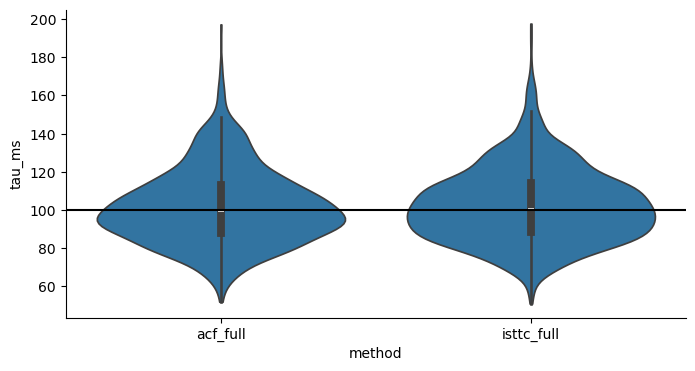

In [108]:
fig, axes = plt.subplots(1,1, figsize=(8,4))

sns.violinplot(ax=axes, x='method', y='tau_ms', data=tau_concat_df, cut=0,  density_norm='width')
axes.axhline(y=target_tau_ms, color='k')

#fig.suptitle('50 signals (len 100s), 30 trials (len 1s) x 50 runs', y=1.05)

sns.despine()

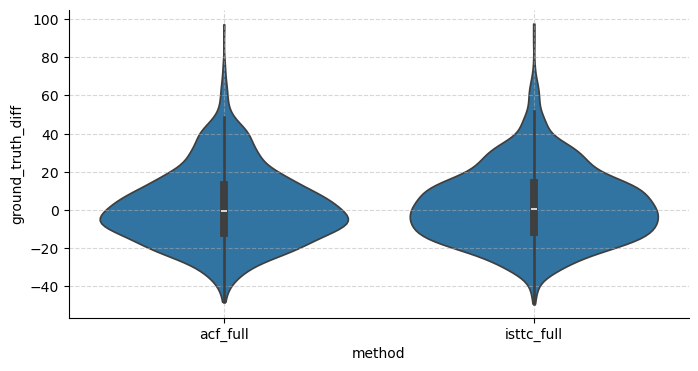

In [111]:
fig, axes = plt.subplots(1,1, figsize=(8,4))

sns.violinplot(ax=axes, x='method', y='ground_truth_diff', data=tau_concat_df, cut=0,  density_norm='width')
axes.grid(True, linestyle='--', alpha=0.5)

#fig.suptitle('50 signals (len 100s), 30 trials (len 1s) x 50 runs', y=1.05)

sns.despine()

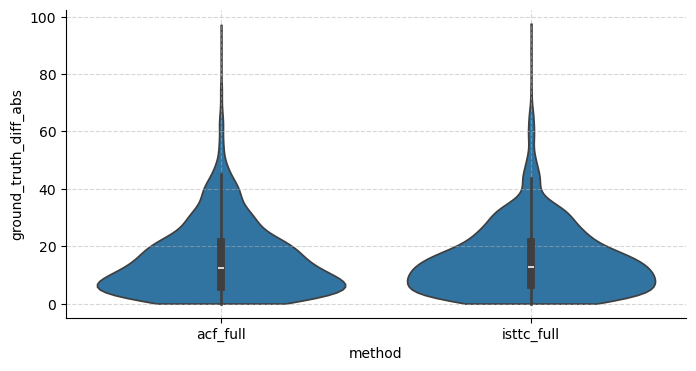

In [113]:
fig, axes = plt.subplots(1,1, figsize=(8,4))

sns.violinplot(ax=axes, x='method', y='ground_truth_diff_abs', data=tau_concat_df, cut=0,  density_norm='width')
axes.grid(True, linestyle='--', alpha=0.5)

#fig.suptitle('50 signals (len 100s), 30 trials (len 1s) x 50 runs', y=1.05)

sns.despine()

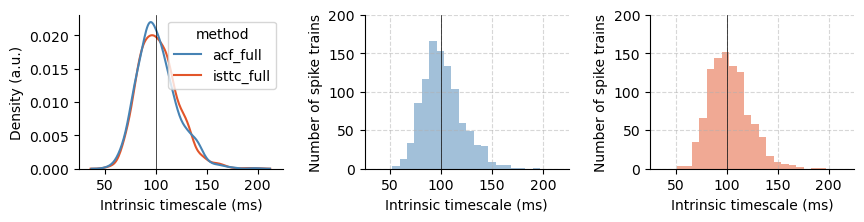

In [105]:
fig, axes = plt.subplots(1,3, figsize=(10,2))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.kdeplot(ax=axes[0],
    data=tau_concat_df,
    x='tau_ms',
    hue='method',
    fill=False,           
    common_norm=False,
    palette = [color_acf_full, color_isttc_full]
)
axes[0].set_ylabel('Density (a.u.)')
#axes[0].legend(frameon=False)

axes[1].hist(acf_full_plot_df['tau_ms'].values, bins=20, color=color_acf_full, alpha=0.5)
axes[1].set_ylabel('Number of spike trains')
axes[1].set_ylim([0, 200])
axes[1].grid(True, linestyle='--', alpha=0.5)

axes[2].hist(acf_isttc_full_plot_df['tau_ms'].values, bins=20, color=color_isttc_full, alpha=0.5)
axes[2].set_ylabel('Number of spike trains')
axes[2].set_ylim([0, 200])
axes[2].grid(True, linestyle='--', alpha=0.5)

for ax in axes.flat:
    ax.axvline(x=target_tau_ms, color='black', lw=0.5)
    ax.set_xlim([25, 225])
    ax.set_xlabel('Intrinsic timescale (ms)')

sns.despine()

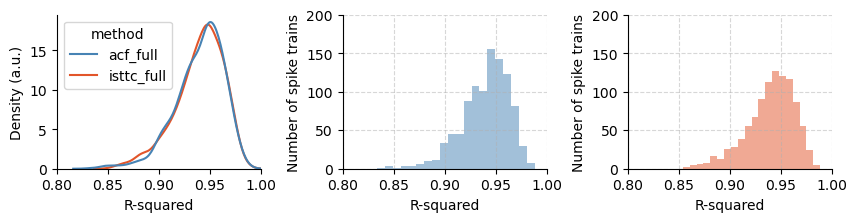

In [103]:
fig, axes = plt.subplots(1,3, figsize=(10,2))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.kdeplot(ax=axes[0],
    data=tau_concat_df,
    x='fit_r_squared',
    hue='method',
    fill=False,           
    common_norm=False,
    palette = [color_acf_full, color_isttc_full]
)
axes[0].set_ylabel('Density (a.u.)')
#axes[0].legend(frameon=False)

axes[1].hist(acf_full_plot_df['fit_r_squared'].values, bins=20, color=color_acf_full, alpha=0.5)
axes[1].set_ylabel('Number of spike trains')
axes[1].set_ylim([0, 200])
axes[1].grid(True, linestyle='--', alpha=0.5)

axes[2].hist(acf_isttc_full_plot_df['fit_r_squared'].values, bins=20, color=color_isttc_full, alpha=0.5)
axes[2].set_ylabel('Number of spike trains')
axes[2].set_ylim([0, 200])
axes[2].grid(True, linestyle='--', alpha=0.5)

for ax in axes.flat:
    ax.set_xlim([0.8, 1])
    ax.set_xlabel('R-squared')

sns.despine()

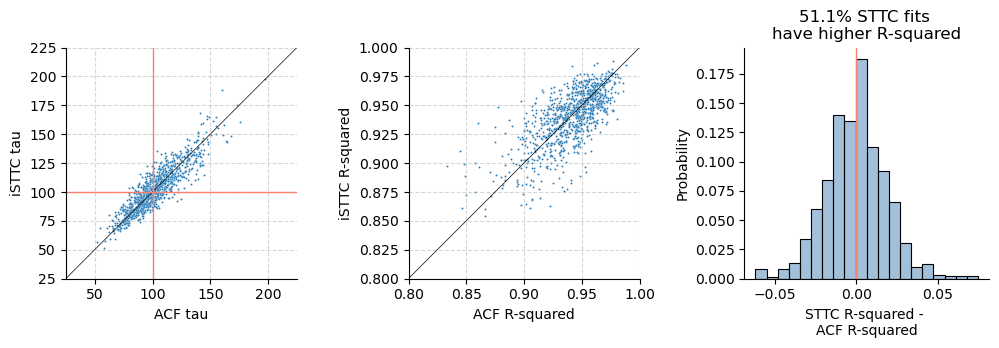

In [128]:
fig, axes = plt.subplots(1,3, figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.scatterplot(ax=axes[0], x=tau_concat_df.query('method == "acf_full"')['tau_ms'].values, 
             y=tau_concat_df.query('method == "isttc_full"')['tau_ms'].values, s=2)
axes[0].plot([0, 1], [0, 1], c='k', transform=axes[0].transAxes, lw=0.5)
axes[0].set_aspect('equal', adjustable='box')
axes[0].set_xlabel('ACF tau')
axes[0].set_ylabel('iSTTC tau')
axes[0].set_xlim([25, 225])
axes[0].set_ylim([25, 225])
axes[0].axvline(x=target_tau_ms, lw=1, c='salmon')
axes[0].axhline(y=target_tau_ms, lw=1, c='salmon')
axes[0].grid(True, linestyle='--', alpha=0.5)

sns.scatterplot(ax=axes[1], x=tau_concat_df.query('method == "acf_full"')['fit_r_squared'].values, 
             y=tau_concat_df.query('method == "isttc_full"')['fit_r_squared'].values, s=2)
axes[1].plot([0, 1], [0, 1], c='k', transform=axes[1].transAxes, lw=0.5)
axes[1].set_aspect('equal', adjustable='box')
axes[1].set_xlabel('ACF R-squared')
axes[1].set_ylabel('iSTTC R-squared')
axes[1].set_xlim([0.8, 1])
axes[1].set_ylim([0.8, 1])
axes[1].grid(True, linestyle='--', alpha=0.5)

r_squared_diff = tau_concat_df.query('method == "isttc_full"')['fit_r_squared'].values - tau_concat_df.query('method == "acf_full"')['fit_r_squared'].values
n_sttc_better = sum(r_squared_diff > 0)
n_sttc_better_perc = n_sttc_better / len(r_squared_diff) * 100

sns.histplot(ax=axes[2], x=r_squared_diff, stat='probability', bins=20, kde=False, color='steelblue', alpha=0.5)
axes[2].axvline(x=0, lw=1, c='salmon')
axes[2].set_xlabel('STTC R-squared - \nACF R-squared')
axes[2].set_title('{}% STTC fits \nhave higher R-squared'.format(np.round(n_sttc_better_perc,2)))

#fig.suptitle('sttc vs acf, allen, n_units = ' + str(len(r_squared_diff)), y=1.15)

sns.despine()


#### Tests